###  Key-finding algorithms: global key and local key detection


#### Task 1: Binary template matching for global key detection


* student: <br>
Tsu-Ching Hsiao / 103062372 <br>
<br>
* description: <br>
This file is the Task 1 of the 2018-spring MIR Homework 1 <br>
written in python 2 <br>
<br>
* dependencies: <br>
    * Numpy
    * Librosa
    * Matplotlib


#### Q1 (20%): complete

In [1]:
# === hyper parameters ===

# dataset path
DATASET_PATH = './genres'
ANNOTATION_PATH = './gtzan_key/gtzan_key/genres'

In [2]:
# === import libraries ===
import numpy as np
import librosa.core
import librosa.display
import os
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# some default params
sampling_rate = 22050
mono = True

# read file
def readAUfile(filepath, silence=True):
    # read file
    y, sr = librosa.core.load(filepath, sampling_rate, mono)
    
    # display file info
    if not silence:
        print('File: {}'.format( os.path.abspath(filepath) ))
        print('Channels: {}'.format( 1 if mono==True else 2 ))
        print('Sampling freq: {} Hz'.format( sampling_rate ))
        print('Total samples: {}'.format( len(y) ))
    return y, sr

In [4]:
def nonlin_chroma(data, sr, gamma=1, chroma_type='stft'):
    if chroma_type == 'stft':
        return np.log(1+gamma*np.abs(librosa.feature.chroma_stft(y=data, sr=sr)))
    elif chroma_type == 'cens':
        return np.log(1+gamma*np.abs(librosa.feature.chroma_cens(y=data, sr=sr)))
    elif chroma_type == 'cqt':
        return np.log(1+gamma*np.abs(librosa.feature.chroma_cqt(y=data, sr=sr)))

Chromagram size:  (12, 1293)


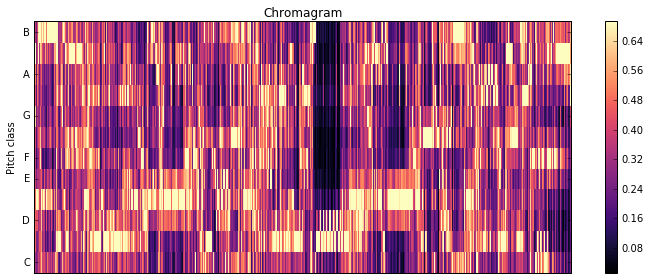

In [5]:
data, sr = readAUfile(os.path.join(DATASET_PATH, 'metal/metal.00001.au'))

# create chromagram
chroma = nonlin_chroma(data, sr, 1)
print('Chromagram size: ', chroma.shape)

# plot chromagram
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

In [6]:
def gen_chord_name():
    major = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
    minor = ['a', 'a#', 'b', 'c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#']
    return major + minor

# Generate chord template
def gen_template():
    template = []
    major_t = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
    minor_t = [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

    def circular_shift(x, sh):
        return x[sh:]+x[:sh]

    # major
    for i in range(3, -9, -1):
        template.append(circular_shift(major_t, i))

    # minor
    for i in range(3, -9, -1):
        template.append(circular_shift(minor_t, i))

    template = np.asarray(template, dtype='float')
    return template

def gen_template(tonic):
    major_t = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
    minor_t = [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]
    
    def circular_shift(x, sh):
        return x[sh:]+x[:sh]
    
    template = [circular_shift(major_t, -tonic), circular_shift(minor_t, -tonic)]
    return np.asarray(template, dtype='float')

In [7]:
def correlation_coef(chroma_vector, template):
    sum_chroma = chroma_vector
    
    mean_x = np.mean(sum_chroma)
    mean_y = np.mean(template, axis=1)
    
    X = sum_chroma-mean_x
    Y = template-mean_y[:, None]
    
    coef = np.sum( X*Y, axis=1 ) / np.sqrt( np.sum(X**2)*np.sum(Y**2, axis=1) )
    return coef

In [8]:
chroma_vec = np.sum(chroma, axis=1)
tonic = np.argmax(chroma_vec)
print('tonic: ', tonic)

template = gen_template(tonic)

coef = correlation_coef(chroma_vec, template)
print('coef size: ', coef.shape)
print(coef)
key = np.argmax(coef)

chord = gen_chord_name()
key = (tonic+3)%12 + 12*key

print('key: ', chord[key])


tonic:  3
coef size:  (2,)
[-0.01246367  0.42902258]
key:  d#


In [9]:
# some utils
def get_genre_filelist(genre):
    path = os.path.join(DATASET_PATH, genre)
    files = sorted([ os.path.join(path, f) for f in os.listdir(path) ])
    return files
    
def get_genre_anno(genre):
    path = os.path.join(ANNOTATION_PATH, genre)
    files = sorted([ os.path.join(path, f) for f in os.listdir(path) ])
    anno = []
    for fp in files:
        with open(fp, 'r') as f:
            anno.append( int(f.read()) )
    return anno

#### Evaluate ( $\gamma = 100$ )


In [10]:
testing_genres = ['pop', 'blues', 'metal', 'hiphop', 'rock']

def eval_once(gamma, chroma_type='stft', silence=True):
    genre_eval_table = []
    genre_predict_label = []
    
    # generate template
    chord = gen_chord_name()
    
    # for each genres
    for genre in testing_genres:
        # create eval table
        eval_table = np.zeros((24, 24), dtype='int')  # (answer, eval)
        predict_label = []
        # get list
        path_list = get_genre_filelist(genre)
        anno_list = get_genre_anno(genre)
    
        for path, anno in zip(path_list, anno_list):
            # skip unknown annotation
            if anno == -1:
                continue
            if not silence:
                print('Working on: ', path)
            
            # read audio file
            data, sr = readAUfile(path)
            
            # create non-linear chromagram
            chroma = nonlin_chroma(data, sr, gamma, chroma_type)
            chroma_vec = np.sum(chroma, axis=1)
            
            # predict
            tonic = np.argmax(chroma_vec)
            template = gen_template(tonic)
            r = (tonic+3)%12 + 12 * np.argmax( correlation_coef(chroma_vec, template) )
            
            eval_table[anno, r] = eval_table[anno, r]+1
            predict_label.append( [os.path.basename(path).rsplit('.au', 1)[0], r] )
            if not silence:
                print('  Label: {} / predict: {}'.format(chord[anno], chord[r]))
                
        genre_eval_table.append(eval_table)
        genre_predict_label.append(predict_label)
    return genre_eval_table, genre_predict_label

In [11]:
# evaluate
q1_table, q1_label = eval_once(100)

In [12]:
print('Complete')

Complete


In [13]:
def draw_table(table, genre):
    axis_font = {'size':'16'}
    label_font = {'size': '20'}
    fig, ax = plt.subplots(figsize=(10,10))
    max_val = table.max
    min_val = table.min
    
    ax.matshow(table, cmap=plt.cm.Blues)
    ax.xaxis.set_ticks(np.arange(0, 24, 1))
    ax.yaxis.set_ticks(np.arange(0, 24, 1))
    chord = gen_chord_name()
    ax.set_xticklabels(chord)
    ax.set_yticklabels(chord)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)
        
    ax.set_ylabel('Answer', **label_font)
    ax.set_xlabel('Predict', **label_font)
    
    
    
    for i in range(24):
        for j in range(24):
            c = table[j, i]
            ax.text(i, j, str(c), va='center', ha='center', **axis_font)
            ax.set_title(genre, **label_font)
            
def output_label(filename, labels):
    with open(filename, 'w') as f:
        for label in labels:
            for l in label:
                f.write('{}\t{}\n'.format(l[0], l[1]))

In [14]:
def accuracy(tables):
    total_test = 0
    total_acc = 0
    acc_list = []
    for table in tables:
        acc = float(np.trace(table))
        total = float(np.sum(table))
        acc_list.append(acc/total)
        
        # append to total
        total_test = total_test + total
        total_acc = total_acc + acc
    
    return total_acc/total_test, acc_list

In [15]:
q1_acc, q1_l = accuracy(q1_table)
print('Total Accuracy: ', q1_acc)
print('each genre: ')
for i in range(len(testing_genres)):
    print('  {}: {}'.format(testing_genres[i], q1_l[i]))
output_label('Q1_{}'.format(100), q1_label)

Total Accuracy:  0.1939655172413793
each genre: 
  pop: 0.35106382978723405
  blues: 0.04081632653061224
  metal: 0.1935483870967742
  hiphop: 0.09876543209876543
  rock: 0.2755102040816326


##### Q1: Discussion

|Genre| Accuracy|
|-|-|
|Total Accuracy| 19.39%|
|pop| 35.10%|
|blues| 4.08%|
|metal| 19.35%|
|hiphop| 9.87%|
|rock| 27.55%|

<br>
As the results of the above, we can see that the accuracy of the genres of 'blues' and 'hiphop' are obviously lower than other 3 genres, and the genre 'blues' have the lowest accuracy. I think that's because the authors of these two genres don't like to use the tonic pitch in their song, the value of the tonic pitch will lower than others. 
<br><br>
Another reason is that there is no any insurence that the chroma, the most frequently appeared, is the tonic pitch of the song. Especially we only have a 30 seconds, which is a very small segment of the song.
<br><br>
From the example in the next cell, we can definitely see that the key G is the most frequently appeared key, so we will guess G is the right key of this song. However, the answer is E minor, which is highly not related to the key G.

Chromagram size:  (12, 1293)
Ranks:  [10  7  4  1  0  5  9 11  8  2  3  6]


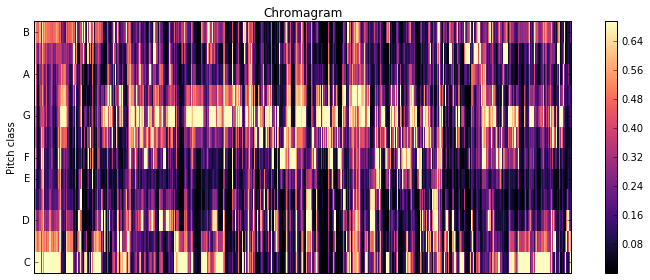

In [16]:
# Example

data, sr = readAUfile(os.path.join(DATASET_PATH, 'blues/blues.00001.au'))

# create chromagram
chroma = nonlin_chroma(data, sr, 1)
print('Chromagram size: ', chroma.shape)
chroma_vec = np.sum(chroma, axis=1)
temp = chroma_vec.argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(chroma_vec))
print('Ranks: ', ranks)

# plot chromagram
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

==========================

#### Q2 (15%): complete

In [17]:
gamma = [1, 10, 100, 1000]
q2_tables = []
q2_labels = []

for g in gamma:
    table, label = eval_once(g)
    output_label('Q2_{}'.format(g), label)
    q2_tables.append(table)
    q2_labels.append(label)
    acc, l = accuracy(table)
    print(' ===== gamma = {} ===== '.format(g))
    print('Total Accuracy: ', acc)
    print('each genre: ')
    for i in range(len(testing_genres)):
        print('  {}: {}'.format(testing_genres[i], l[i]))

 ===== gamma = 1 ===== 
Total Accuracy:  0.23706896551724138
each genre: 
  pop: 0.4148936170212766
  blues: 0.07142857142857142
  metal: 0.21505376344086022
  hiphop: 0.13580246913580246
  rock: 0.336734693877551
 ===== gamma = 10 ===== 
Total Accuracy:  0.21982758620689655
each genre: 
  pop: 0.40425531914893614
  blues: 0.04081632653061224
  metal: 0.1935483870967742
  hiphop: 0.14814814814814814
  rock: 0.30612244897959184
 ===== gamma = 100 ===== 
Total Accuracy:  0.1939655172413793
each genre: 
  pop: 0.35106382978723405
  blues: 0.04081632653061224
  metal: 0.1935483870967742
  hiphop: 0.09876543209876543
  rock: 0.2755102040816326
 ===== gamma = 1000 ===== 
Total Accuracy:  0.1939655172413793
each genre: 
  pop: 0.3404255319148936
  blues: 0.05102040816326531
  metal: 0.1935483870967742
  hiphop: 0.08641975308641975
  rock: 0.2857142857142857


##### Q2: Discussion
|Gamma|Accuracy|
|-----|--------|
|1|23.70%|
|10|21.98%|
|100|19.39%|
|1000|19.39%|

The highest accuracy (23.70%) occurred when gamma = 1
<br><br>
This phenomenon is produced by the features of the logarithm, since the logarithmic scale would reduce the interval for higher values. Hence, if we use bigger gamma value, $1+\gamma|x|$ will scale up the original feature values, and $\log(1+\gamma|x|)$ will reduce the differences between each feature values. So if we increase the gamma value, it will become more difficult to detect the features.

=============================

#### Q3 (20%): complete

In [18]:
def new_accuracy(tables):
    total_test = 0
    total_acc = 0
    acc_list = []
    for table in tables:
        acc = 0
        acc += float(np.trace(table))
        for c in range(24):
            fif = (c+7)%12 + c//12*12
            rel = (c+9)%12 + (1-c//12)*12
            par = (c+12)%24
            acc += 0.5 * float(table[c][fif])
            acc += 0.3 * float(table[c][rel])
            acc += 0.2 * float(table[c][par])
        total = float(np.sum(table))
        acc_list.append(acc/total)
        
        # append to total
        total_test = total_test + total
        total_acc = total_acc + acc
    
    return total_acc/total_test, acc_list

In [19]:
for g, table in zip(gamma, q2_tables):
    acc, l = new_accuracy(table)
    print(' ===== gamma = {} ===== '.format(g))
    print('Total Accuracy: ', acc)
    print('each genre: ')
    for i in range(len(testing_genres)):
        print('  {}: {}'.format(testing_genres[i], l[i]))

 ===== gamma = 1 ===== 
Total Accuracy:  0.3355603448275863
each genre: 
  pop: 0.5319148936170214
  blues: 0.17142857142857143
  metal: 0.3
  hiphop: 0.2024691358024691
  rock: 0.4551020408163266
 ===== gamma = 10 ===== 
Total Accuracy:  0.31724137931034485
each genre: 
  pop: 0.5297872340425533
  blues: 0.1326530612244898
  metal: 0.264516129032258
  hiphop: 0.21111111111111108
  rock: 0.43571428571428583
 ===== gamma = 100 ===== 
Total Accuracy:  0.2920258620689656
each genre: 
  pop: 0.4755319148936171
  blues: 0.12448979591836738
  metal: 0.264516129032258
  hiphop: 0.16049382716049382
  rock: 0.41836734693877564
 ===== gamma = 1000 ===== 
Total Accuracy:  0.2903017241379311
each genre: 
  pop: 0.4670212765957447
  blues: 0.12653061224489795
  metal: 0.264516129032258
  hiphop: 0.14814814814814814
  rock: 0.4265306122448981


|Gamma|Accuracy|
|-|-|
|1|33.55%|
|10|31.72%|
|100|29.20%|
|1000|29.03%|

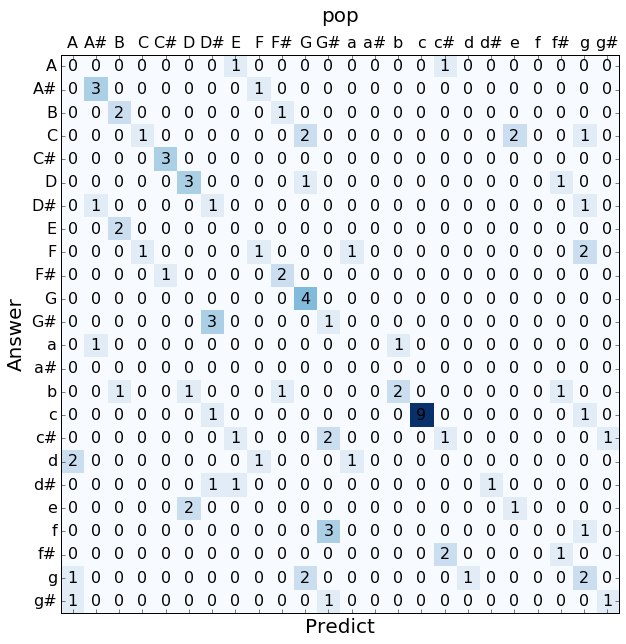

In [20]:
draw_table(q2_tables[0][0], 'pop')

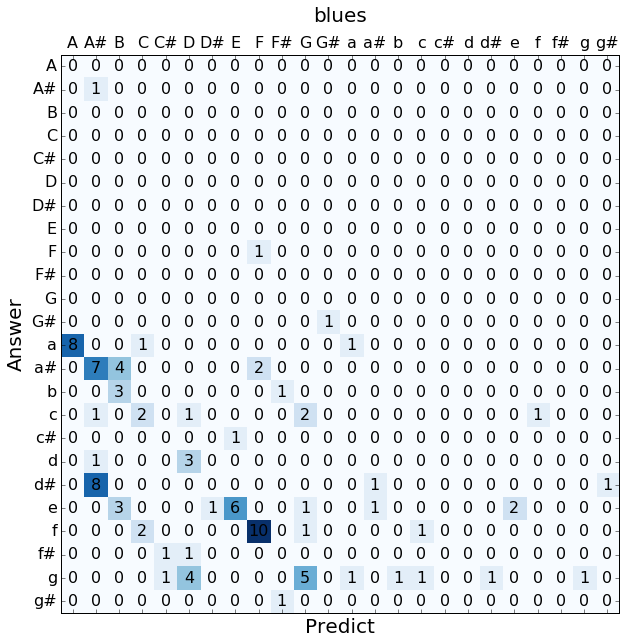

In [21]:
draw_table(q2_tables[0][1], 'blues')

##### Q3: Discussion

The above two figures show the detection results of the best and worst genres, 'pop' and 'blues', respectively. 
<br><br>
We can discover that for 'pop' genre, there are two lines clearly exist, both are the relation of 'Same' and 'Perfect fifth' to the correct key. For 'blues' genre, the clearest line is the relation of 'Paralle major/miner' to the correct answer. So if we include those relations into the part of the results, then we can get higher accuracy. 

Chromagram size:  (12, 1293)
Ranks:  [10  7  4  1  0  5  9 11  8  2  3  6]
Chromagram size:  (12, 1293)
Ranks:  [10  7  4  1  0  5  9 11  8  2  3  6]
Chromagram size:  (12, 1293)
Ranks:  [ 9  6  4  0  1  5 10 11  8  2  3  7]
Chromagram size:  (12, 1293)
Ranks:  [ 9  6  4  0  1  5 10 11  8  2  3  7]


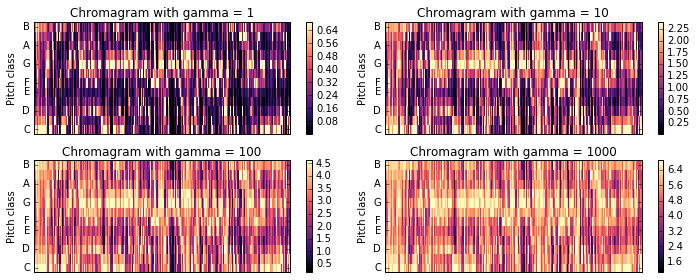

In [24]:
data, sr = readAUfile(os.path.join(DATASET_PATH, 'blues/blues.00001.au'))
chromagrams = []

plt.figure(figsize=(10, 4))
for idx, gamma in enumerate([1, 10, 100, 1000]):
    # create chromagram
    chroma = nonlin_chroma(data, sr, gamma)
    print('Chromagram size: ', chroma.shape)
    chroma_vec = np.sum(chroma, axis=1)
    temp = chroma_vec.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(chroma_vec))
    print('Ranks: ', ranks)
    
    plt.subplot(2, 2, idx+1)
    
    
    chromagrams.append(chroma)
    librosa.display.specshow(chroma, y_axis='chroma')
    plt.colorbar()
    plt.title('Chromagram with gamma = {}'.format(gamma))

plt.tight_layout()